In [2]:
import random

import numpy as np
import matplotlib.pyplot as plt

import scipy as sp
from scipy import stats

from sklearn.utils import shuffle
from sklearn.covariance import MinCovDet
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix

In [3]:
def load_dataset(dataset_name):
    dataset = np.load(dataset_name, allow_pickle=True)
    X = dataset[()]['x']
    Y = dataset[()]['y']
    return X, Y

In [4]:
Enterface_X, Enterface_Y = load_dataset('datasets/enterface.npy')
Meld_X, Meld_Y = load_dataset('datasets/meld.npy')
full_X = np.concatenate((Enterface_X, Meld_X), axis=0)
full_Y = np.concatenate((Enterface_Y, Meld_Y), axis=0)

### Análisis de correlaciones entre features

In [4]:
rho, pval = stats.spearmanr(full_X)

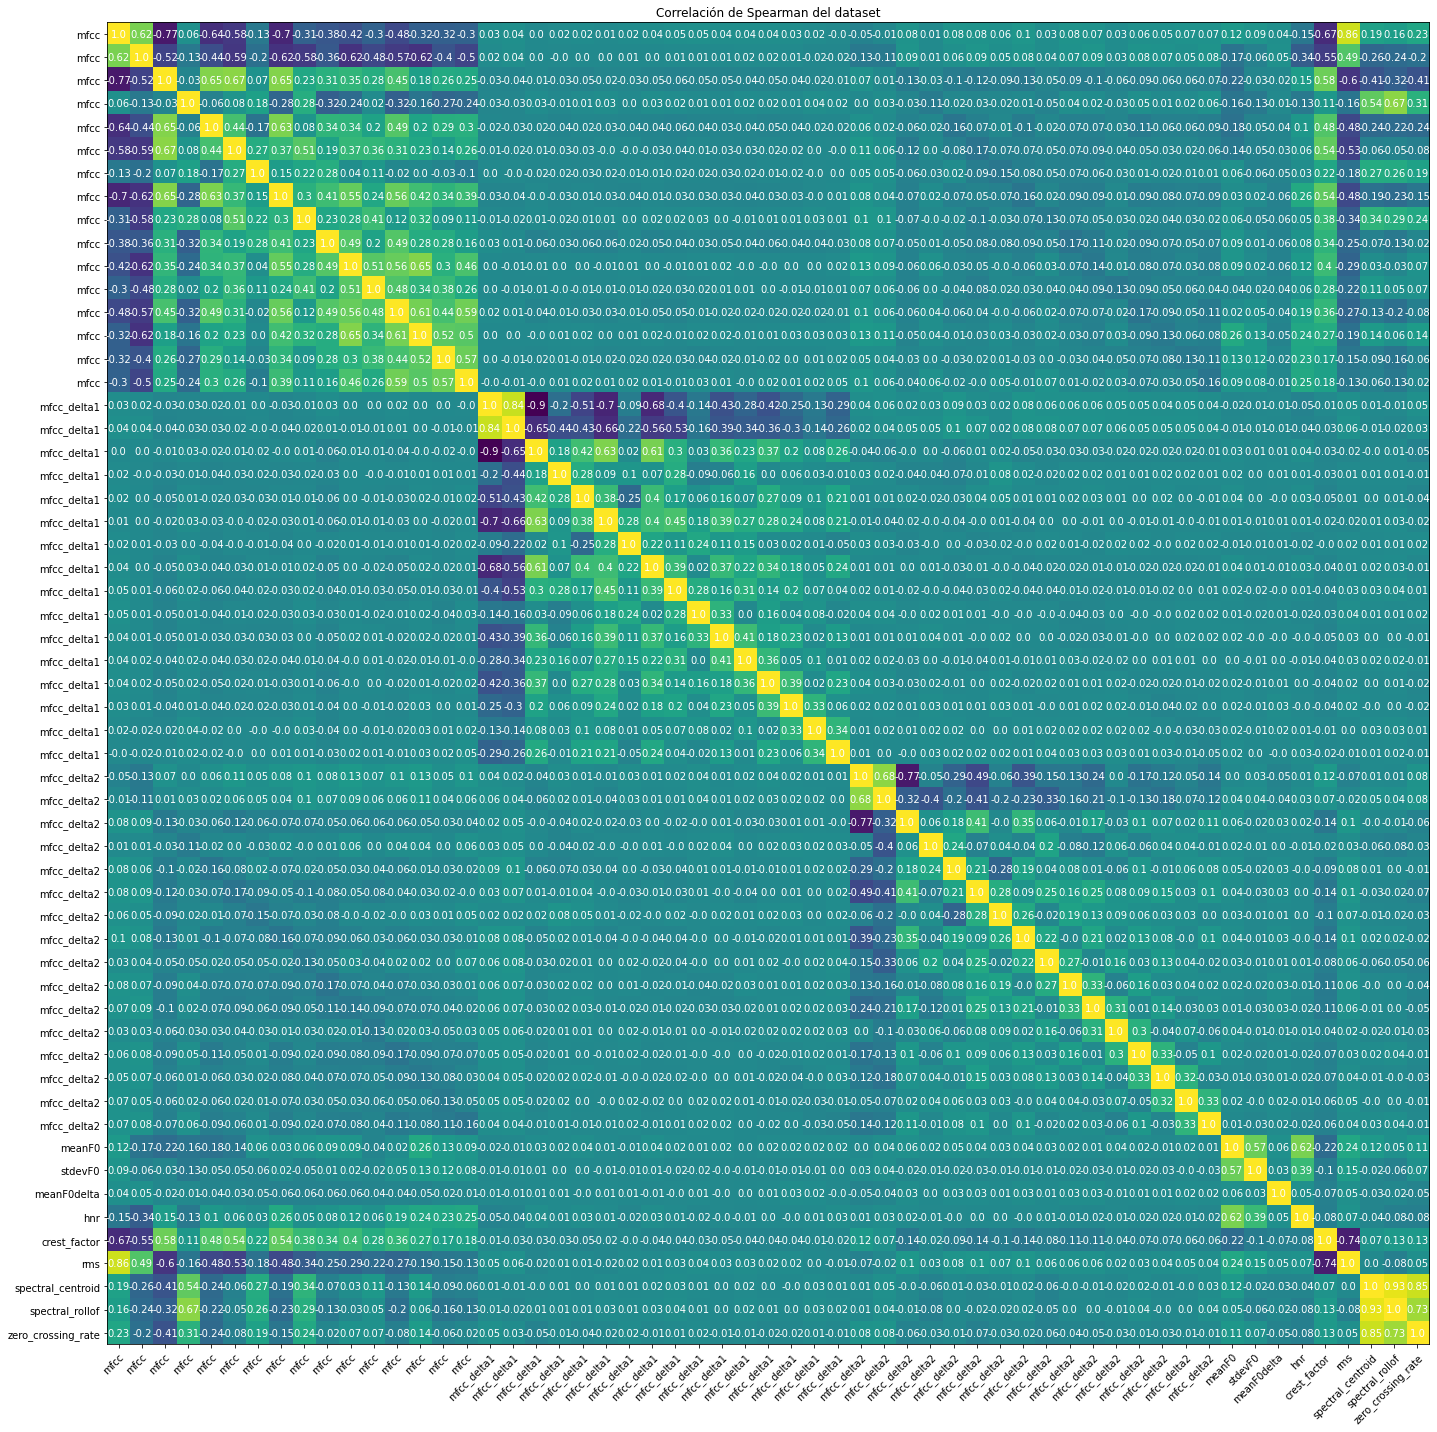

In [5]:

feature_names = ['mfcc'] * 16 + ['mfcc_delta1'] * 16 + ['mfcc_delta2'] * 16 +[
    "meanF0",
    "stdevF0",
    "meanF0delta",
    "hnr",
    "crest_factor",
    "rms",
    # "f_means",
    # "f_medians",
    "spectral_centroid",
    "spectral_rollof",
    "zero_crossing_rate",
]

fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(rho)

# We want to show all ticks...
ax.set_xticks(np.arange(len(feature_names)))
ax.set_yticks(np.arange(len(feature_names)))
# ... and label them with the respective list entries
ax.set_xticklabels(feature_names)
ax.set_yticklabels(feature_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        text = ax.text(j, i, round(rho[i, j], 2),
                       ha="center", va="center", color="w")

ax.set_title("Correlación de Spearman del dataset")
fig.tight_layout()
plt.show()

#### Se encuentran altas correlaciones entre los features Spectral_centroid, spectral_rollof y zero_crossing_rate, como es de esperarse debido a su origen común. También se encuentra una correlación alta entre RMS y el primer MFCC. En los casos de spectral_centroid, spectral_rollof y zero_crossing_rate se utiliza una técnica de proyección PCA que logre incluir la mayor cantidad de información de estos tres parámetros en un solo valor. En el caso de RMS y el primer valor de MFCC se ignora debido a que posteriormente se decide no utilizar el RMS.

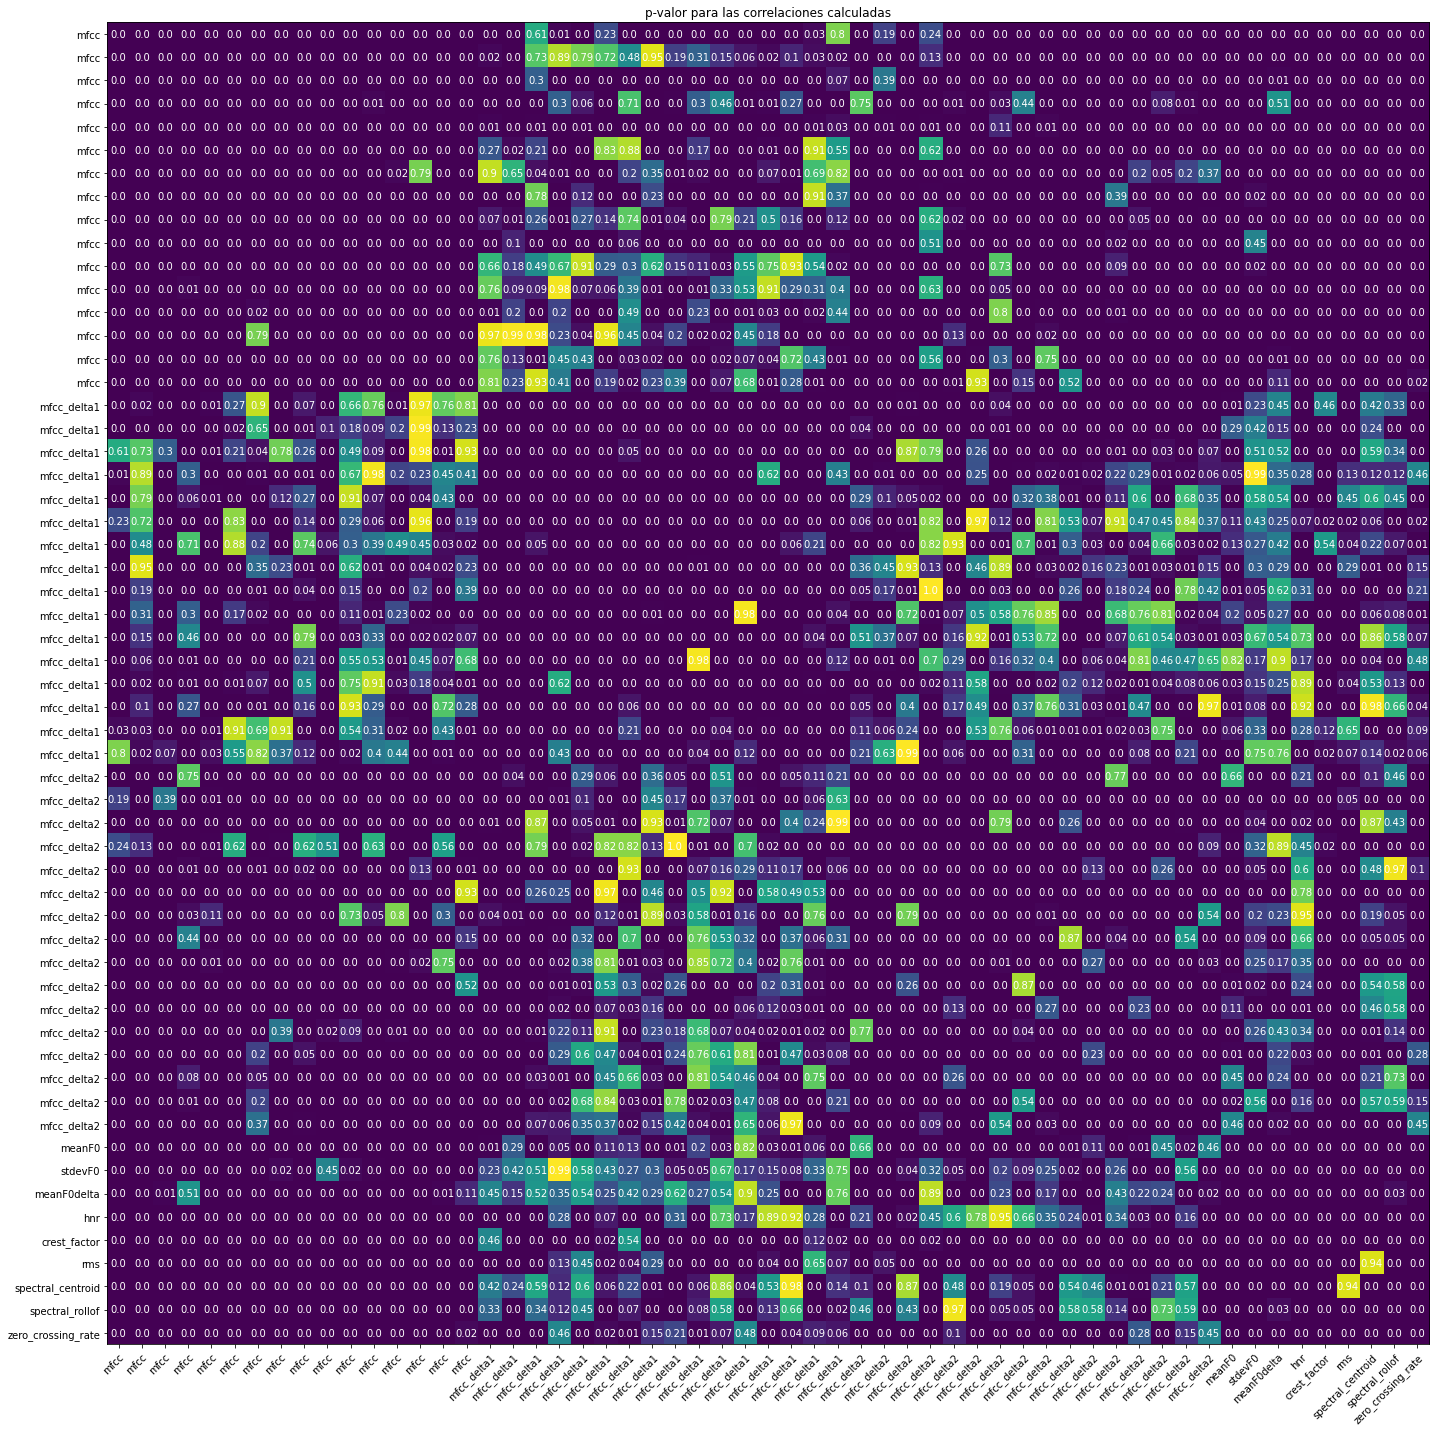

In [6]:
feature_names = ['mfcc'] * 16 + ['mfcc_delta1'] * 16 + ['mfcc_delta2'] * 16 +[
    "meanF0",
    "stdevF0",
    "meanF0delta",
    "hnr",
    "crest_factor",
    "rms",
    # "f_means",
    # "f_medians",
    "spectral_centroid",
    "spectral_rollof",
    "zero_crossing_rate",
]

fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(pval)

# We want to show all ticks...
ax.set_xticks(np.arange(len(feature_names)))
ax.set_yticks(np.arange(len(feature_names)))
# ... and label them with the respective list entries
ax.set_xticklabels(feature_names)
ax.set_yticklabels(feature_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        text = ax.text(j, i, round(pval[i, j], 2),
                       ha="center", va="center", color="w")

ax.set_title("p-valor para las correlaciones calculadas")
fig.tight_layout()
plt.show()

#### Proyección PCA de los features altamente correlados

In [5]:
pca_meld = PCA(n_components=1)
pca_meld_result = pca_meld.fit_transform(np.array(Meld_X)[:,-3:])
print('meld: ', pca_meld.explained_variance_ratio_)
pca_enterface = PCA(n_components=1)
pca_enterface_result = pca_enterface.fit_transform(np.array(Enterface_X)[:,-3:])
print('enterface: ', pca_enterface.explained_variance_ratio_)
pca_full = PCA(n_components=1)
pca_full_result = pca_full.fit_transform(np.array(full_X)[:,-3:])
print('full: ', pca_full.explained_variance_ratio_)

meld:  [0.98007329]
enterface:  [0.99184445]
full:  [0.98133207]


In [6]:
meld_x = np.delete(Meld_X, -1, 1)
meld_x = np.delete(meld_x, -1, 1)
meld_x = np.delete(meld_x, -1, 1)
meld_x = np.c_[ meld_x, pca_meld_result ]
enterface_x = np.delete(Enterface_X, -1, 1)
enterface_x = np.delete(enterface_x, -1, 1)
enterface_x = np.delete(enterface_x, -1, 1)
enterface_x = np.c_[ enterface_x, pca_enterface_result ]
full_x = np.delete(full_X, -1, 1)
full_x = np.delete(full_x, -1, 1)
full_x = np.delete(full_x, -1, 1)
full_x = np.c_[ full_x, pca_full_result ]

### Balanceo y normalización
Este no es el definitivo. Se hace para obtener la importancia de cada feature pero después de eliminar los outliers se va a hacer de nuevo.

In [7]:
def dataset_normalization(dataset, n_mfcc):
    dataset = np.array(dataset)
    for n in range(3):
        mean = np.mean(dataset[:, n * n_mfcc : (n + 1) * n_mfcc])
        std = np.std(dataset[:, n * n_mfcc : (n + 1) * n_mfcc])
        dataset[:, n * n_mfcc : (n + 1) * n_mfcc] = (
            dataset[:, n * n_mfcc : (n + 1) * n_mfcc] - mean
        ) / std
    N = n_mfcc * 3
    mean = np.mean(dataset[:, N:], axis=0)
    std = np.std(dataset[:, N:], axis=0)
    dataset[:, N:] = (dataset[:, N:] - mean) / std
    return dataset

def downsample(x_dataset, y_dataset, condition, rate):
    l = np.count_nonzero(np.array(y_dataset) == condition)
    n = int(l*rate)
    indexes = list(np.where(np.array(y_dataset) == condition)[0])
    indexes = random.sample(indexes, n)
    x = np.delete(np.array(x_dataset), indexes, 0)
    y = np.delete(y_dataset, indexes, 0)
    return x, y
    

In [10]:
enterface_x = dataset_normalization(enterface_x, 16)
meld_x = dataset_normalization(meld_x, 16)
full_x = dataset_normalization(full_x, 16)

In [9]:
enterface_x_downsampled, enterface_y_downsampled = downsample(enterface_x, Enterface_Y, 0, 0.5)
enterface_positives = np.count_nonzero(np.array(enterface_y_downsampled) == 1)
enterface_negatives = np.count_nonzero(np.array(enterface_y_downsampled) == 0)
print(enterface_positives)
print(enterface_negatives)
meld_x_downsampled, meld_y_downsampled = downsample(meld_x, Meld_Y, 0, 0.5)
meld_positives = np.count_nonzero(np.array(meld_y_downsampled) == 1)
meld_negatives = np.count_nonzero(np.array(meld_y_downsampled) == 0)
print(meld_positives)
print(meld_negatives)   
full_x_downsampled, full_y_downsampled = downsample(full_x, full_Y, 0, 0.5)
full_positives = np.count_nonzero(np.array(full_y_downsampled) == 1)
full_negatives = np.count_nonzero(np.array(full_y_downsampled) == 0)
print(full_positives)
print(full_negatives)

495
573
4069
5081
4564
5654


### Feature Selection

In [12]:
x_train, x_test, y_train, y_test = train_test_split(np.array(full_x_downsampled), np.array(full_y_downsampled), test_size=0.1, random_state=9)

In [13]:
model = ExtraTreesClassifier(n_estimators=1500, max_features=0.5, max_depth=10)
model.fit(x_train, y_train)

ExtraTreesClassifier(max_depth=10, max_features=0.5, n_estimators=1500)

In [14]:
feature_importance = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)


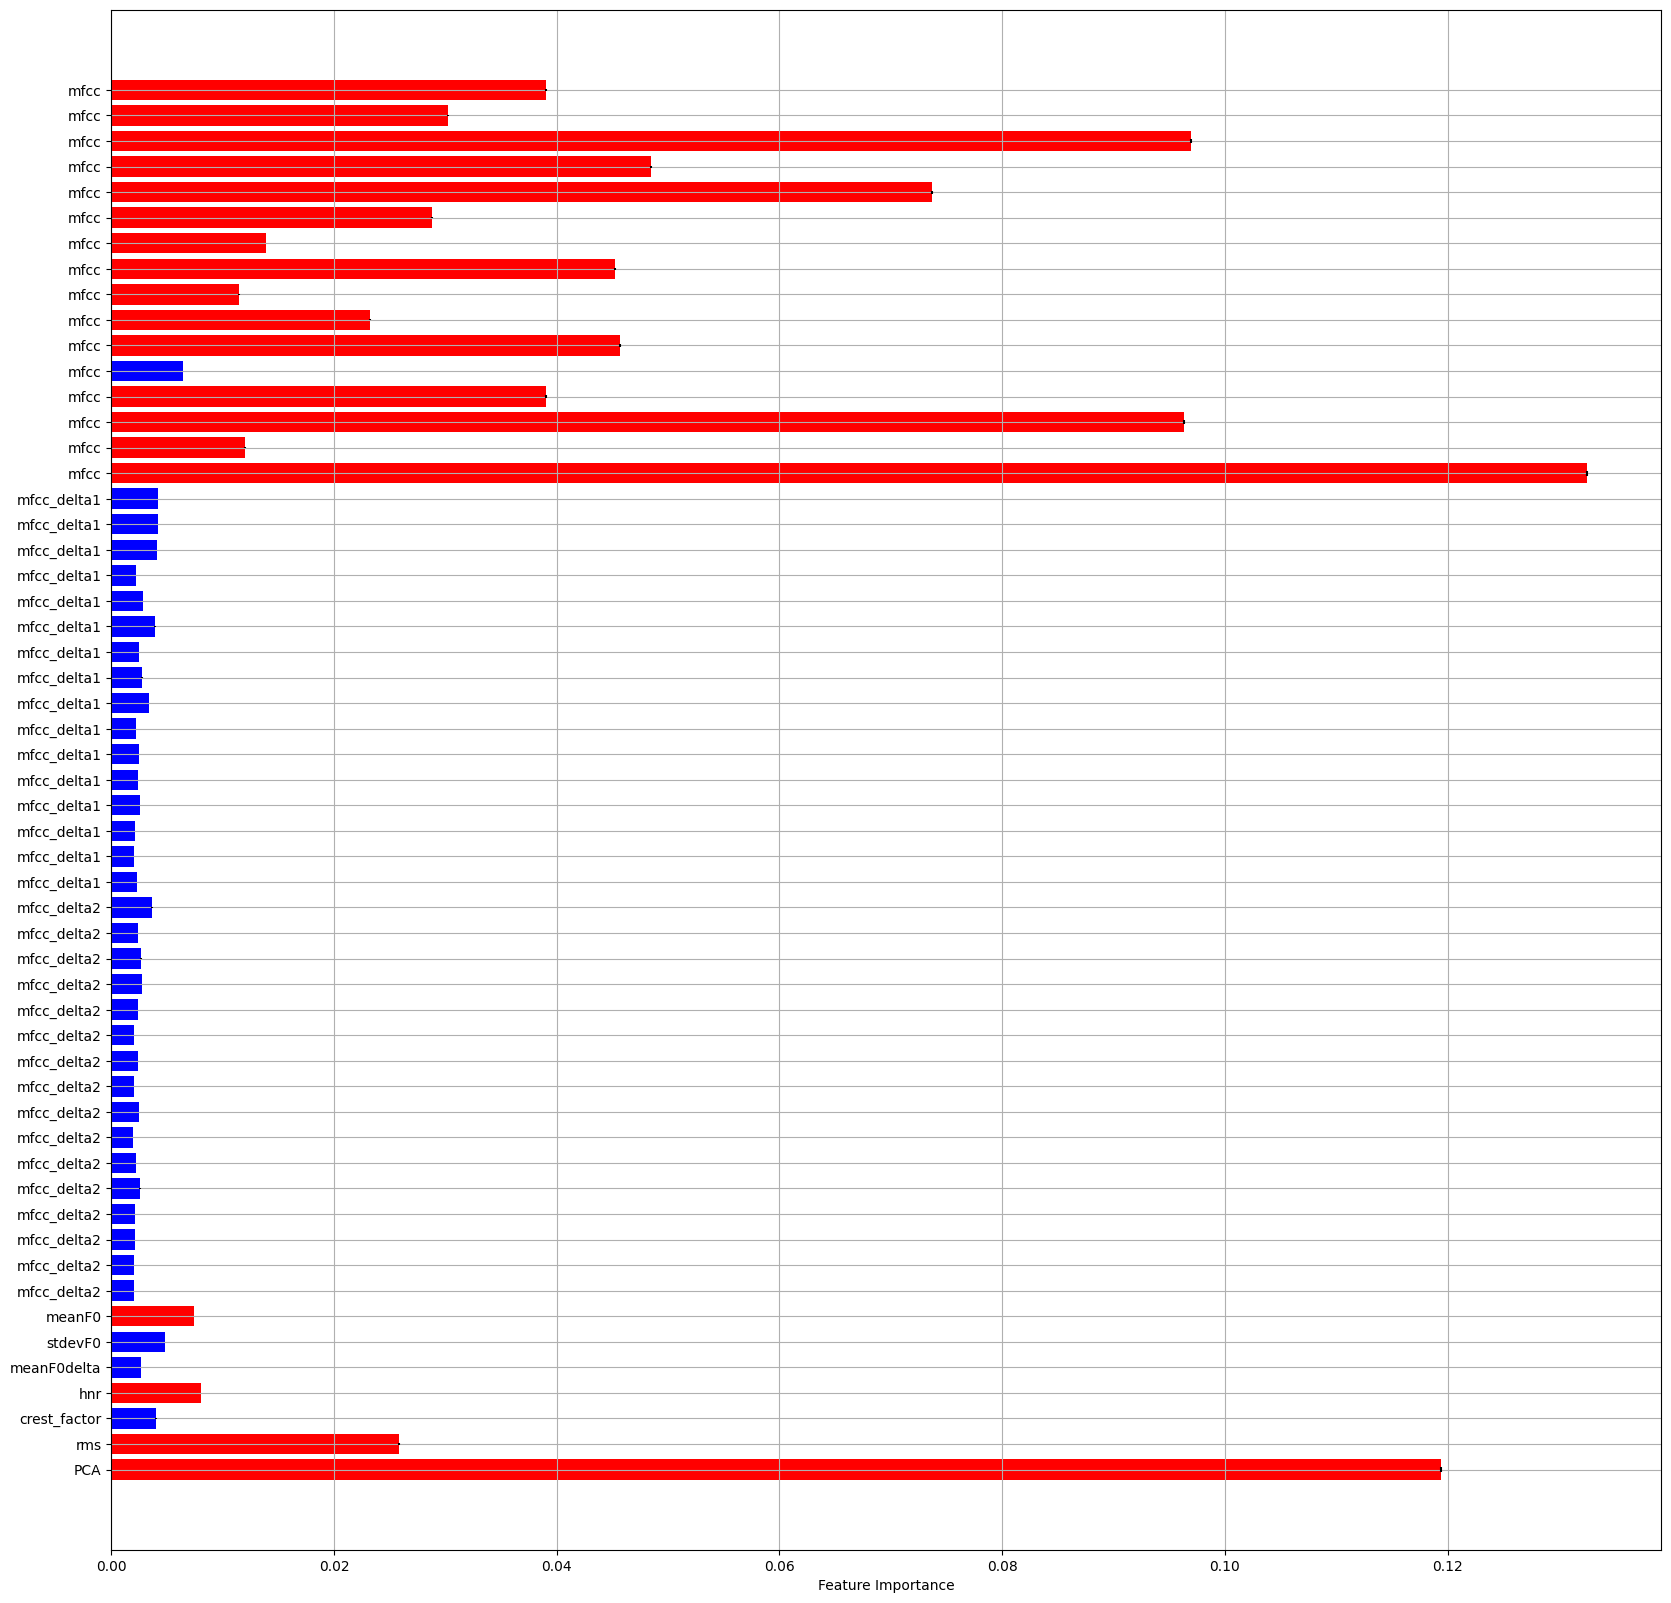

In [15]:
feature_names = ['mfcc'] * 16 + ['mfcc_delta1'] * 16 + ['mfcc_delta2'] * 16 +[
    "meanF0",
    "stdevF0",
    "meanF0delta",
    "hnr",
    "crest_factor",
    "rms",
    # "f_means",
    # "f_medians",
    "PCA"
]
n_top = 19
plt.rcdefaults()

fig, ax = plt.subplots(figsize=(20,20))
top = np.argpartition(feature_importance, -n_top)[-n_top:]

colors = np.array(['blue'] * len(feature_importance))
colors[top] = 'red'

y_pos = np.arange(len(feature_names))
ax.barh(y_pos, feature_importance, yerr=std, align='center', color=colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.grid()
plt.show()

In [16]:
def metrics(x_test, y_test, x_train, y_train, model):
    y_pred = model.predict(x_test)
    threshold = 0.5
    y_pred_binary = []
    for pred in y_pred:
        if pred > threshold:
            y_pred_binary.append(1)
        else:
            y_pred_binary.append(0)

    conf = confusion_matrix(y_test, y_pred_binary)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
    accuracy = (tp + tn) / (fn + fp + tp + tn) #Exactitud, porcentaje de predicciones correctas
    precision = tp / (fp + tp) #Precisión, porcentaje de predicciones positivas correctas
    specifity = tn / (tn + fn) #Especificidad, porcentaje de casos negativos detectados correctamente
    recall = tp / (tp + fn) # sensibilidad, porcentaje de casos positivos detectados
    true_negative_rate = tn / (tn + fp)
    F1_score = precision * 2 * recall / (precision + recall)

    y_pred = model.predict(x_train)
    threshold = 0.5
    y_pred_binary = []
    for pred in y_pred:
        if pred > threshold:
            y_pred_binary.append(1)
        else:
            y_pred_binary.append(0)

    conf = confusion_matrix(y_train, y_pred_binary)
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred_binary).ravel()
    accuracy_train = (tp + tn) / (fn + fp + tp + tn) #Exactitud, porcentaje de predicciones correctas
    precision_train = tp / (fp + tp) #Precisión, porcentaje de predicciones positivas correctas
    specifity_train = tn / (tn + fn) #Especificidad, porcentaje de casos negativos detectados correctamente
    recall_train = tp / (tp + fn) # sensibilidad, porcentaje de casos positivos detectados
    true_negative_rate_train = tn / (tn + fp)
    F1_score_train = precision_train * 2 * recall_train / (precision_train + recall_train)
    print('Exactitud: ', accuracy, '/ ', accuracy_train)
    print('Precisión: ', precision, '/ ', precision_train)
    print('Especificidad: ', specifity, '/ ', specifity_train)
    print('Sensibilidad: ', recall, '/ ', recall_train)
    print(' true_negative_rate: ', true_negative_rate, '/ ', true_negative_rate_train)
    print('F1 - Score: ', F1_score, '/ ', F1_score_train)

In [17]:
metrics(x_test, y_test, x_train, y_train, model)

Exactitud:  0.8414872798434442 /  0.8813614615050022
Precisión:  0.9319526627218935 /  0.9849020237712818
Especificidad:  0.7967836257309941 /  0.8283741574880815
Sensibilidad:  0.6938325991189427 /  0.745985401459854
 true_negative_rate:  0.9595070422535211 /  0.9907589461266221
F1 - Score:  0.7954545454545454 /  0.8489547279523745


In [18]:
result = permutation_importance(
    model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=1, scoring='recall'
)

[]

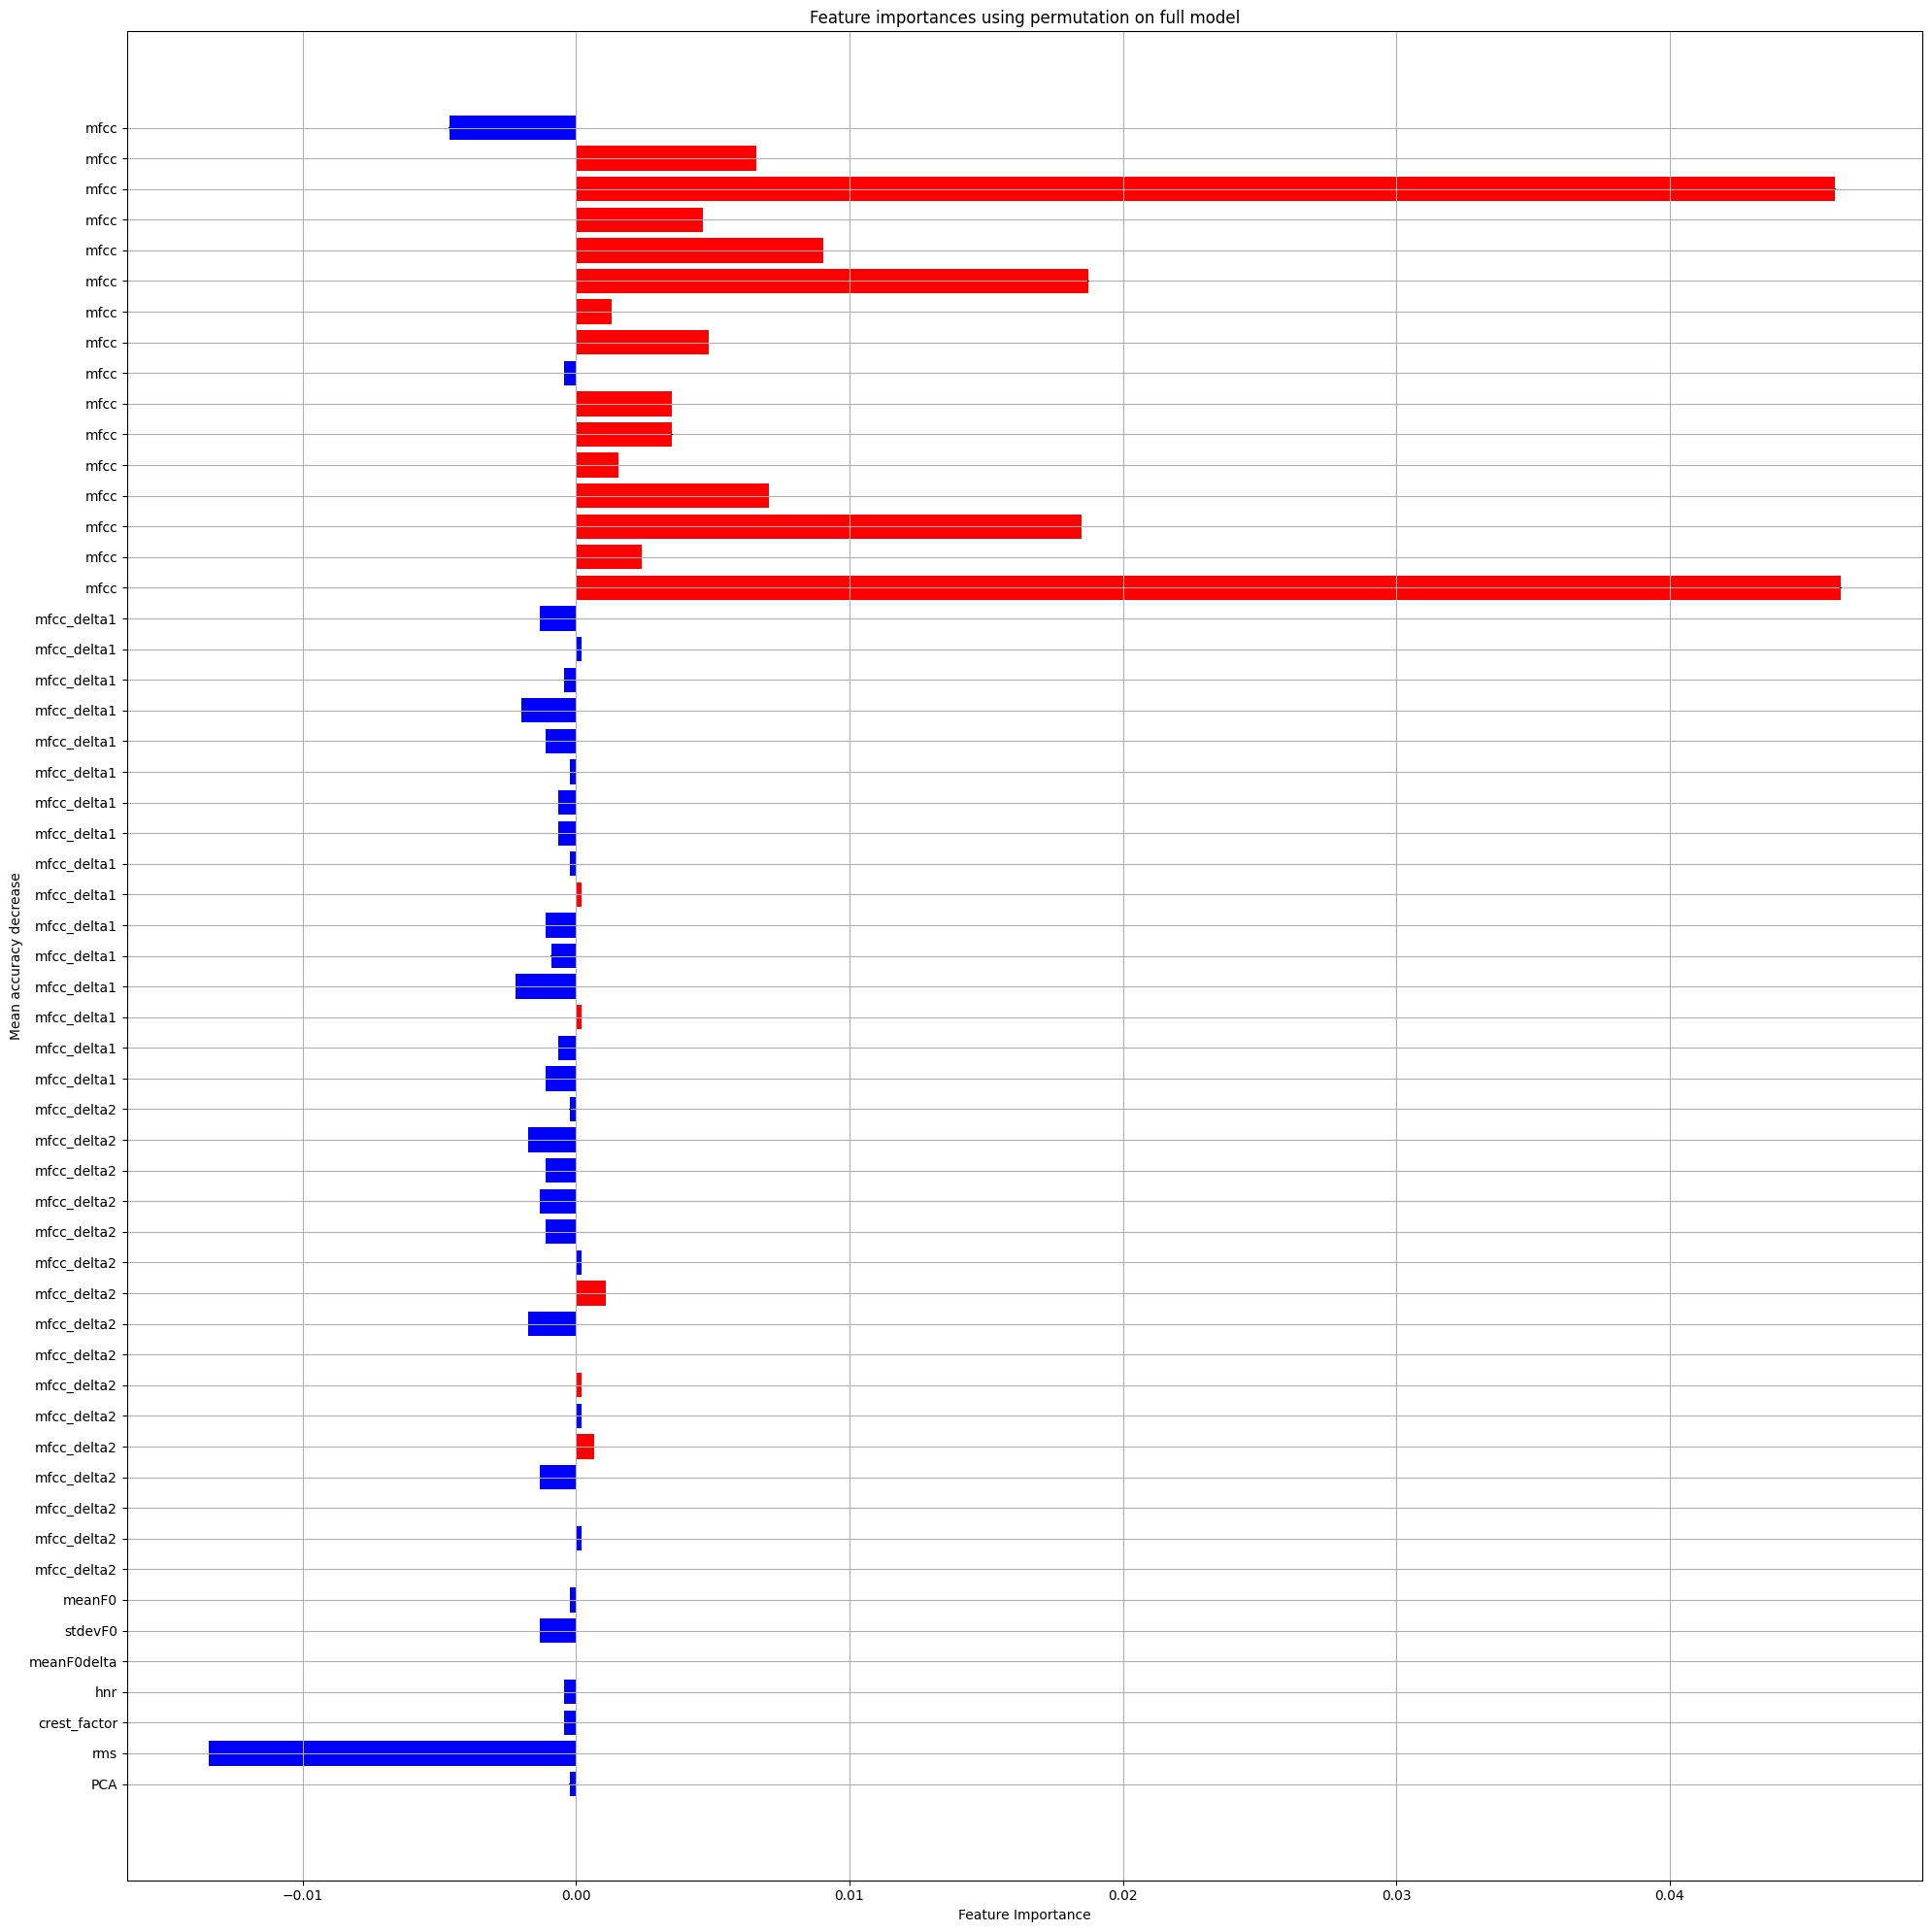

In [19]:

fig, ax = plt.subplots(figsize=(20,20))
top = np.argpartition(result.importances_mean, -n_top)[-n_top:]

colors = np.array(['blue'] * len(feature_importance))
colors[top] = 'red'

y_pos = np.arange(len(feature_names))
ax.barh(y_pos, result.importances_mean, yerr=result.importances_std, align='center', color=colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')

ax.grid()
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
ax.plot()

#### En primer lugar se eliminarán las derivadas del MFCC y luego se calculará la importancia nuevamente.

In [20]:
full_x_downsampled = np.delete(full_x_downsampled, slice(16, 48),1)


In [21]:
x_train, x_test, y_train, y_test = train_test_split(np.array(full_x_downsampled), np.array(full_y_downsampled), test_size=0.1, random_state=9)

In [22]:
model = ExtraTreesClassifier(n_estimators=1500, max_features=0.5, max_depth=10)
model.fit(x_train, y_train)

ExtraTreesClassifier(max_depth=10, max_features=0.5, n_estimators=1500)

In [23]:
feature_importance = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
feature_names = ['mfcc'] * 16 +[
    "meanF0",
    "stdevF0",
    "meanF0delta",
    "hnr",
    "crest_factor",
    "rms",
    # "f_means",
    # "f_medians",
    "PCA"
]

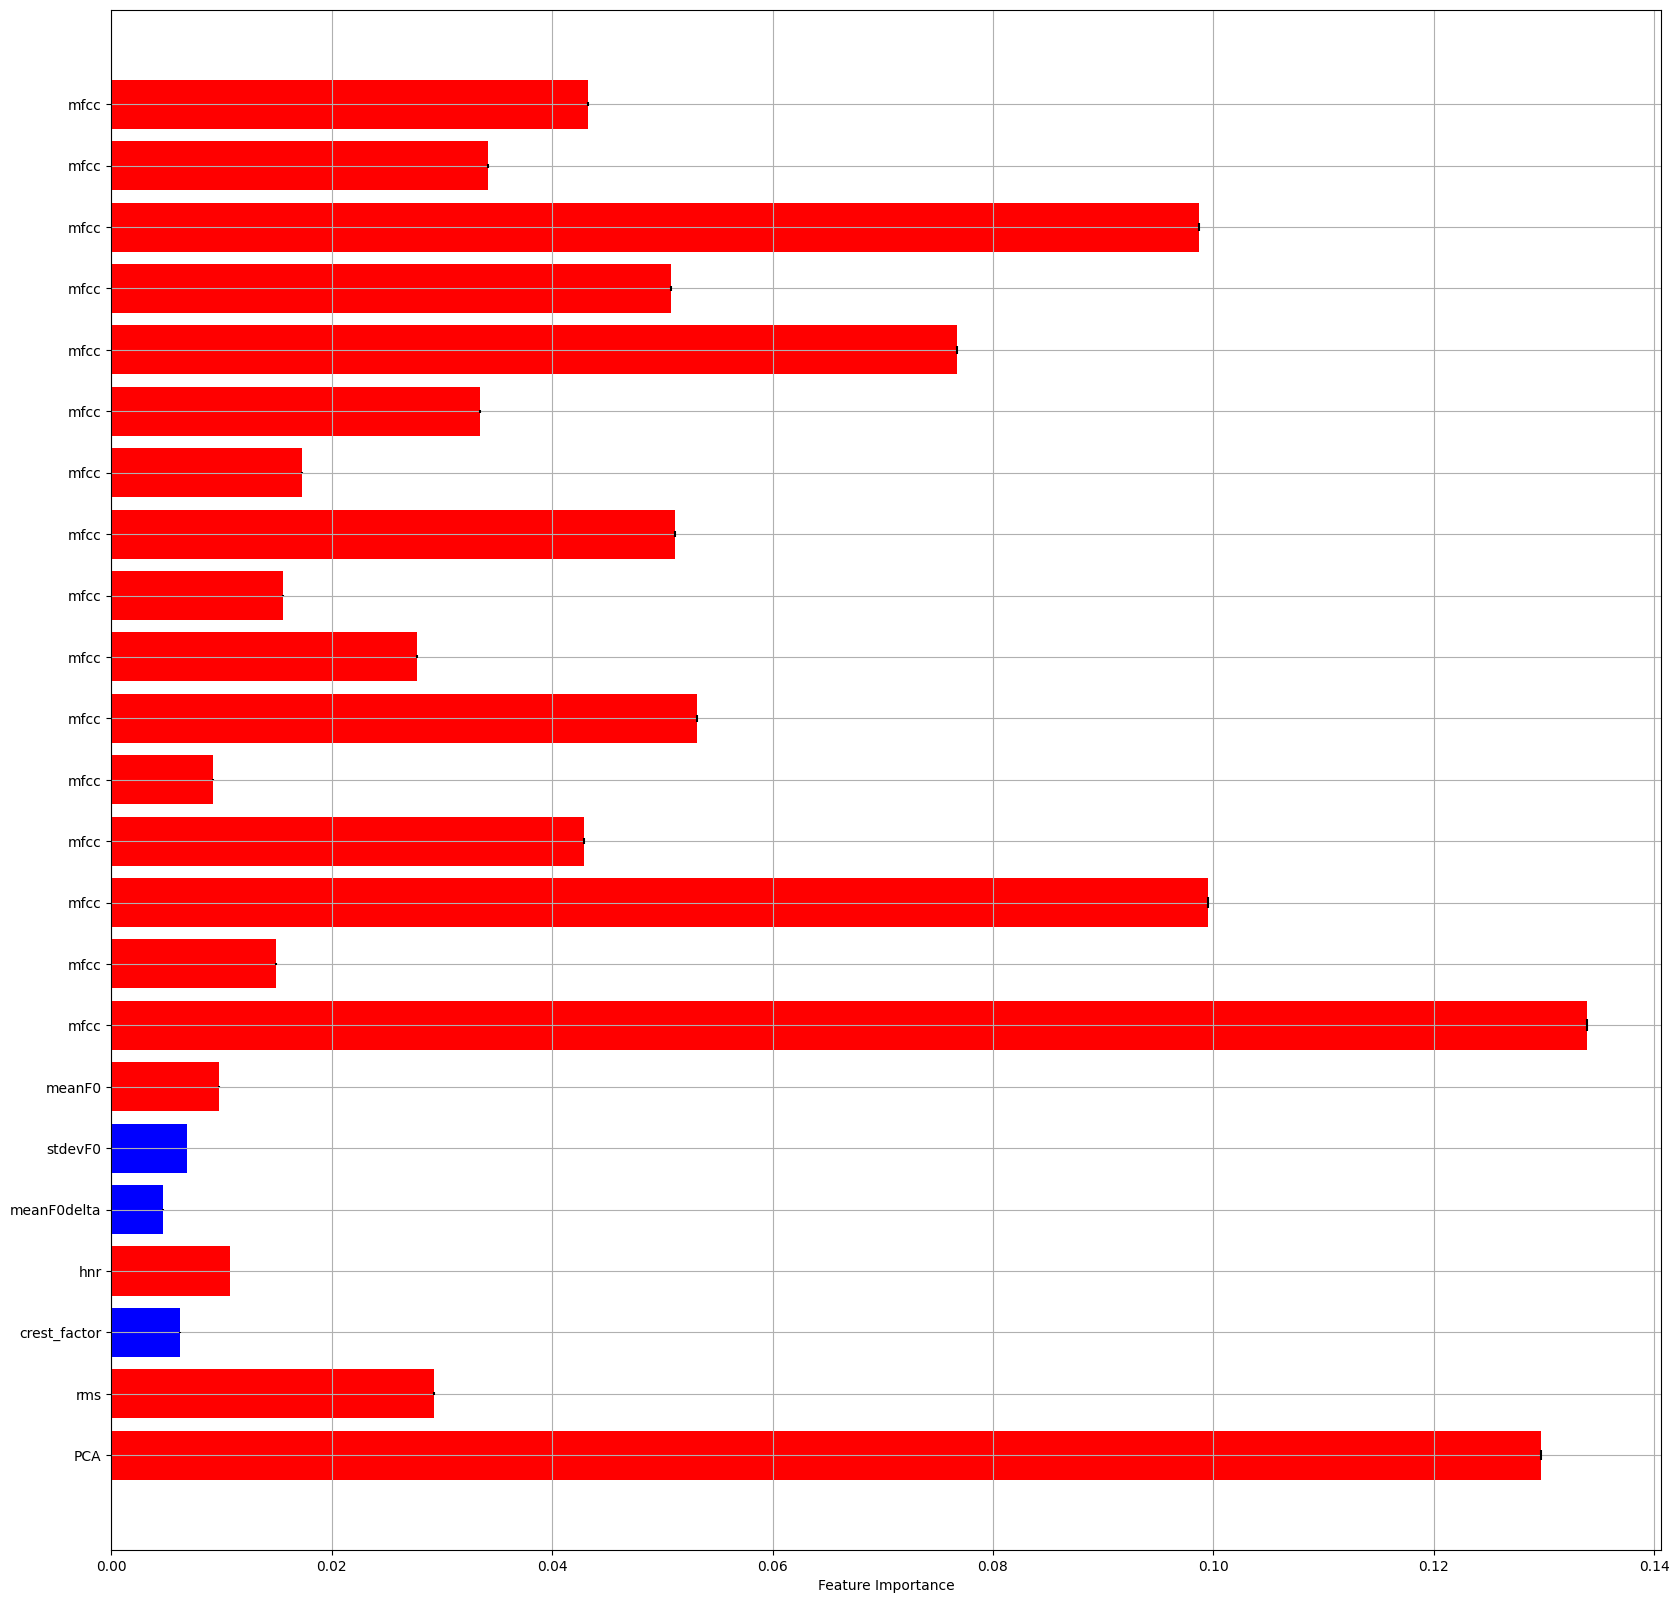

In [24]:
n_top = 20
plt.rcdefaults()

fig, ax = plt.subplots(figsize=(20,20))
top = np.argpartition(feature_importance, -n_top)[-n_top:]

colors = np.array(['blue'] * len(feature_importance))
colors[top] = 'red'

y_pos = np.arange(len(feature_names))
ax.barh(y_pos, feature_importance, yerr=std, align='center', color=colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.grid()
plt.show()

In [25]:
metrics(x_test, y_test, x_train, y_train, model)

Exactitud:  0.8385518590998043 /  0.8769030013049152
Precisión:  0.9262536873156342 /  0.9784704370179949
Especificidad:  0.7950219619326501 /  0.8249506903353058
Sensibilidad:  0.6916299559471366 /  0.7408759124087592
 true_negative_rate:  0.9559859154929577 /  0.9868265827762486
F1 - Score:  0.7919293820933165 /  0.8432567155912489


In [26]:
result = permutation_importance(
    model, x_test, y_test, n_repeats=10, random_state=42, n_jobs=1, scoring='recall'
)

[]

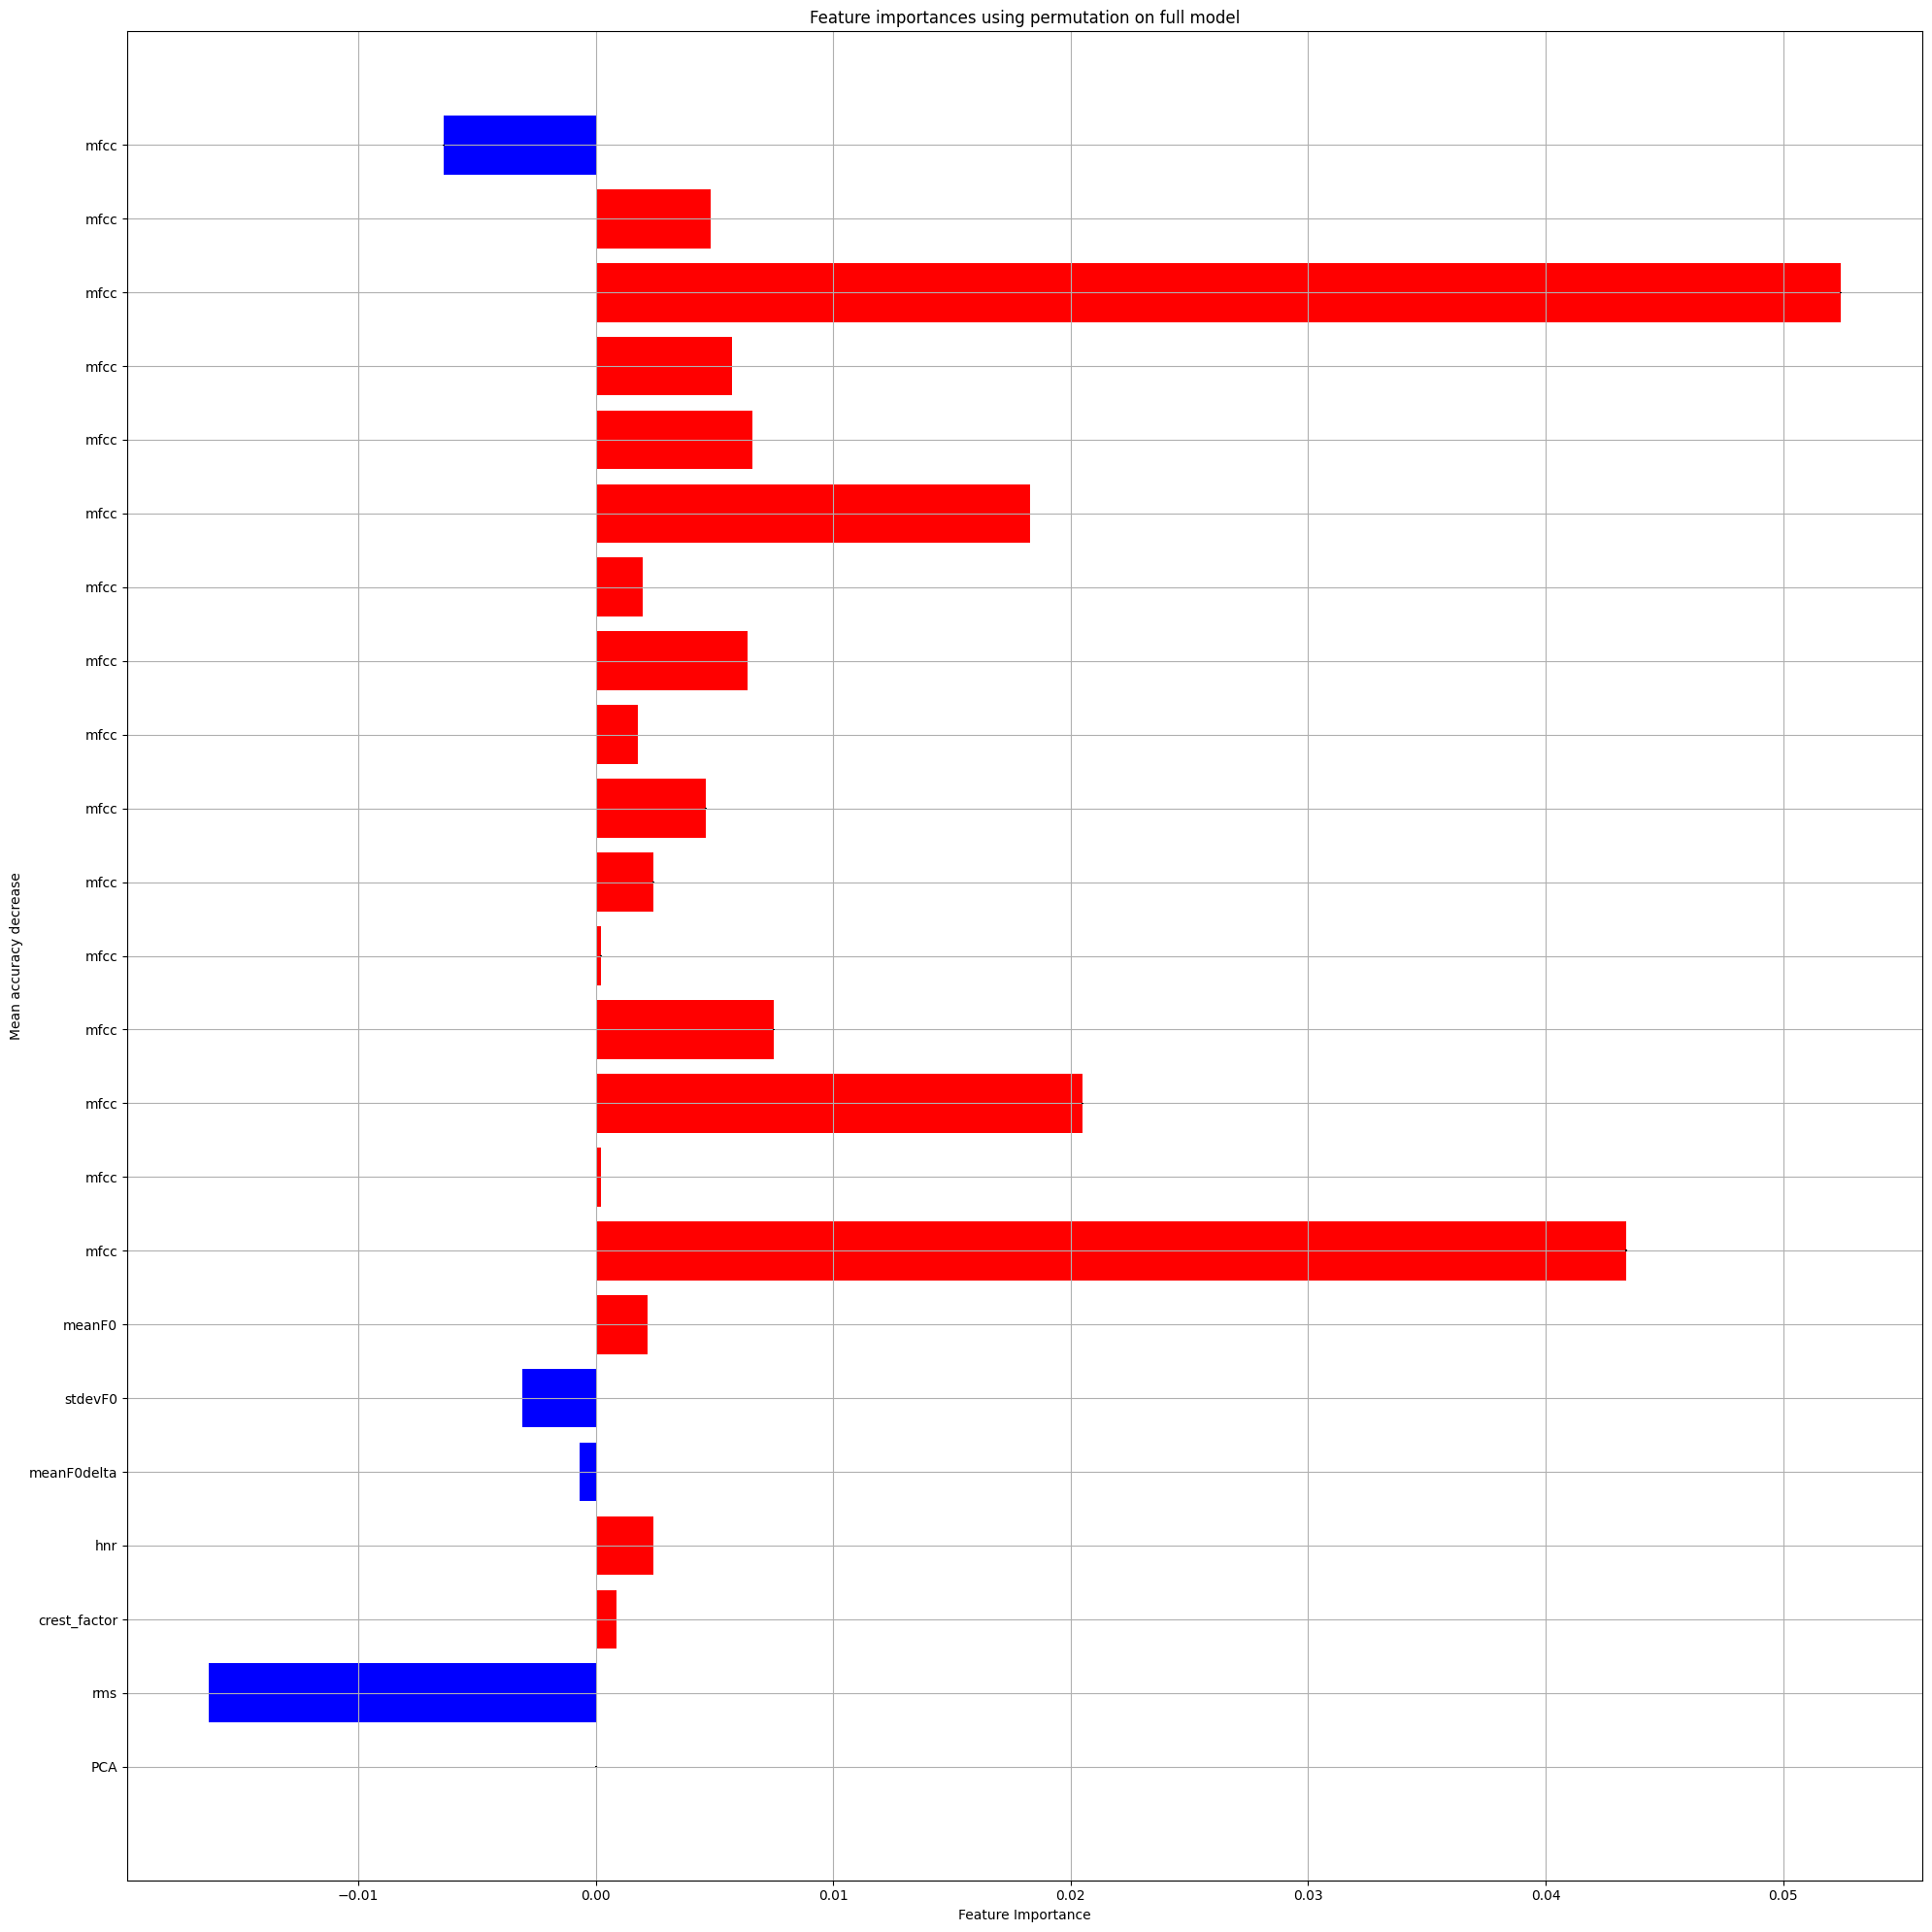

In [27]:
n_top = 19  
fig, ax = plt.subplots(figsize=(20,20))
top = np.argpartition(result.importances_mean, -n_top)[-n_top:]

colors = np.array(['blue'] * len(feature_importance))
colors[top] = 'red'

y_pos = np.arange(len(feature_names))
ax.barh(y_pos, result.importances_mean, yerr=result.importances_std, align='center', color=colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')

ax.grid()
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
ax.plot()

In [51]:
result.importances

array([[-0.00881057, -0.00881057, -0.00660793, -0.00660793, -0.00660793,
        -0.00660793, -0.00440529,  0.00220264, -0.01101322, -0.00660793],
       [ 0.00220264,  0.00220264,  0.00220264,  0.00881057,  0.00881057,
         0.        ,  0.        ,  0.00881057,  0.00881057,  0.00660793],
       [ 0.05286344,  0.05066079,  0.06167401,  0.05066079,  0.05947137,
         0.05286344,  0.04405286,  0.05066079,  0.05506608,  0.04625551],
       [ 0.00440529,  0.00660793,  0.00660793,  0.00440529,  0.00660793,
         0.00660793,  0.00881057,  0.00660793,  0.00881057, -0.00220264],
       [ 0.00660793,  0.00660793,  0.00660793,  0.00220264,  0.00881057,
         0.00660793,  0.00660793,  0.00881057,  0.01101322,  0.00220264],
       [ 0.01982379,  0.01762115,  0.02643172,  0.0154185 ,  0.0154185 ,
         0.02202643,  0.01982379,  0.00881057,  0.0154185 ,  0.02202643],
       [-0.00220264,  0.00660793,  0.00440529, -0.00220264,  0.00220264,
         0.00440529,  0.        , -0.00220264

Se deciden eliminar RMS, stdev, meanF0delta y crest_factor

In [28]:
full_x = enterface_x
full_Y = Enterface_Y


In [8]:
full_x = np.delete(full_x, slice(16, 48),1) # Elimino las derivadas del MFCC
full_x = np.delete(full_x, [-2, -3, -5, -6],1) # Elimino RMS, Crest Factor, Mean F0 delta y std dev F0
full_x.shape


(15871, 19)

#### Ahora se deben buscar los outliers para eliminarlos. Esto se realiza a partir de la distancia de mahalanobis

In [9]:
def robust_outliers(x):
    #Minimum covariance determinant
    rng = np.random.RandomState(0)
    real_cov = np.cov(x.T)
    X = rng.multivariate_normal(mean=np.mean(x, axis=0), cov=real_cov, size=506)
    cov = MinCovDet(random_state=0).fit(X)
    mcd = cov.covariance_ #robust covariance metric
    robust_mean = cov.location_  #robust mean
    inv_covmat = sp.linalg.inv(mcd) #inverse covariance metric
    
    #Robust M-Distance
    x_minus_mu = x - robust_mean
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    C = np.sqrt(stats.chi2.ppf((1-0.001), df=19))#degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

In [10]:
def outliers(x):
    mu = np.mean(x, axis=0)
    x_minus_mu = x - mu
    cov = np.cov(x.T)
    inv_cov = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_cov) 
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    #Flag as outlier
    outlier = []
    #Cut-off point
    C = np.sqrt(stats.chi2.ppf((1-0.001), df=19))    #degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier

In [11]:

positive_indexes = np.where(np.array(full_Y) == 1)
negative_indexes = np.where(np.array(full_Y) == 0)
negative_cases = full_x[negative_indexes]
positive_cases = full_x[positive_indexes]

In [12]:
positive_outliers = outliers(positive_cases)
print(len(positive_outliers))
negative_outliers = outliers(negative_cases)
print(len(negative_outliers))

195
562


In [13]:
robust_positive_outliers, _ = robust_outliers(positive_cases)
print(len(robust_positive_outliers))
robust_negative_outliers, _ = robust_outliers(negative_cases)
print(len(robust_negative_outliers))

285
772


In [14]:
positive_no_outliers = np.delete(positive_cases, robust_positive_outliers,0)
negative_no_outliers = np.delete(negative_cases, robust_negative_outliers,0)


In [15]:
full_no_outliers = np.concatenate((positive_no_outliers, negative_no_outliers),axis=0)
full_no_outliers.shape

(14814, 19)

In [16]:
y = list(np.ones(len(positive_no_outliers), dtype=int)) + list(np.zeros(len(negative_no_outliers), dtype=int))
len(y)

14814

In [17]:
x, y = shuffle(full_no_outliers, y, random_state=0)

In [18]:
general_outliers, _ = robust_outliers(x)
x_no_outliers = np.delete(x, general_outliers,0)
y_no_outliers = np.delete(y, general_outliers,0)
x_no_outliers.shape


(14189, 19)

In [19]:
positives = np.count_nonzero(np.array(y_no_outliers) == 1)
negatives = np.count_nonzero(np.array(y_no_outliers) == 0)
print(positives, negatives)

3909 10280


In [20]:
x_downsampled, y_downsampled = downsample(x_no_outliers, y_no_outliers, 0, 0.62)
enterface_positives = np.count_nonzero(np.array(y_downsampled) == 1)
enterface_negatives = np.count_nonzero(np.array(y_downsampled) == 0)
print(enterface_negatives, enterface_positives)

3907 3909


In [42]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x_downsampled), np.array(y_downsampled), test_size=0.1, random_state=9)

In [43]:
model = ExtraTreesClassifier(n_estimators=1500, max_features=0.5, max_depth=10)
model.fit(x_train, y_train)

ExtraTreesClassifier(max_depth=10, max_features=0.5, n_estimators=1500)

In [44]:
feature_importance = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
feature_names = ['mfcc'] * 16 +[
    "meanF0",
    "hnr",
    "PCA"
]

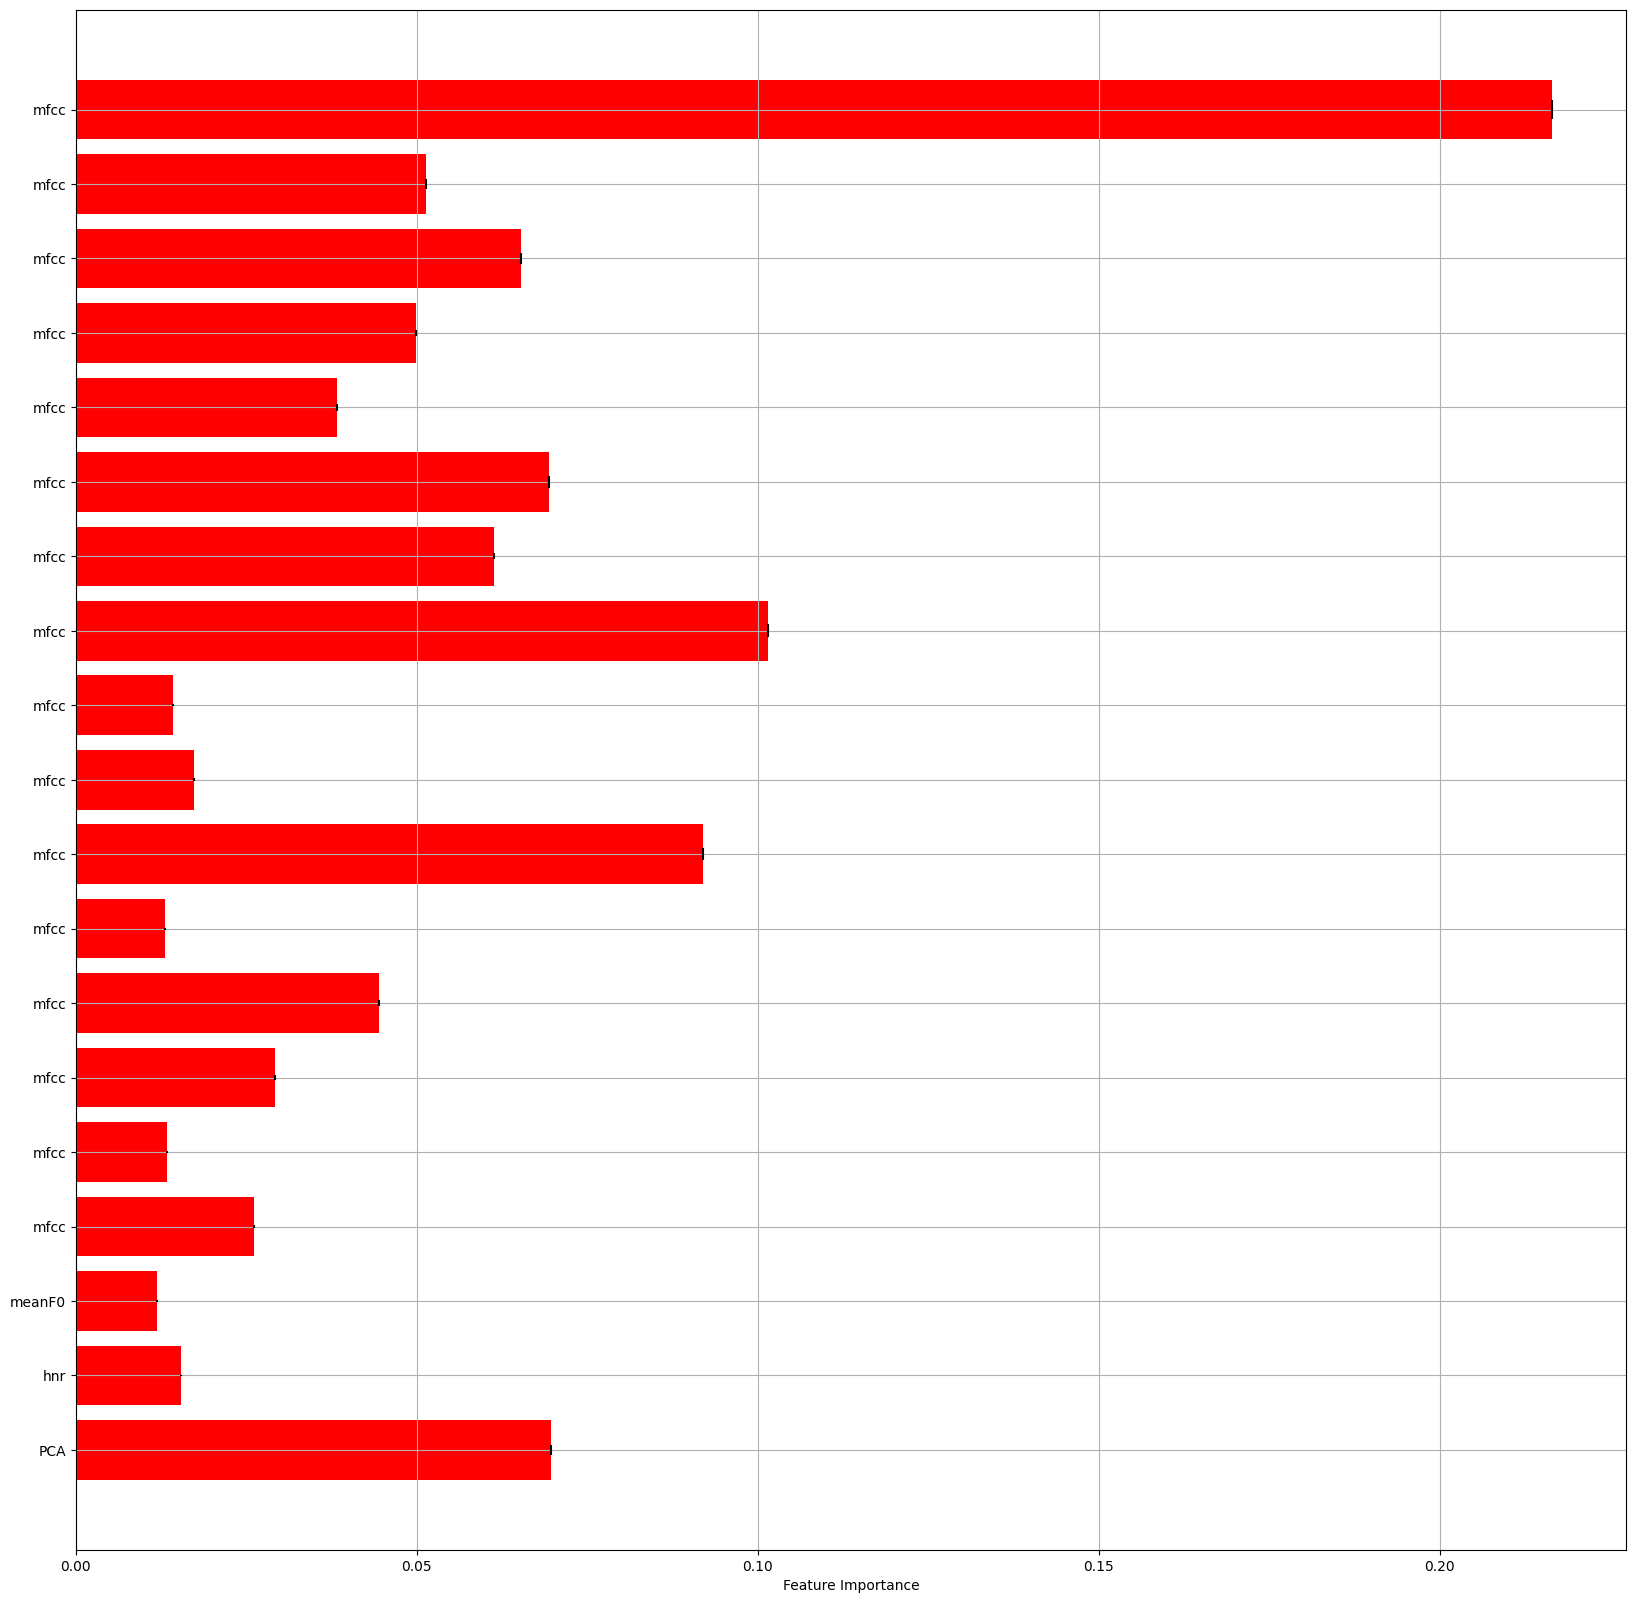

In [45]:
n_top = 19
plt.rcdefaults()

fig, ax = plt.subplots(figsize=(20,20))
top = np.argpartition(feature_importance, -n_top)[-n_top:]

colors = np.array(['blue'] * len(feature_importance))
colors[top] = 'red'

y_pos = np.arange(len(feature_names))
ax.barh(y_pos, feature_importance, yerr=std, align='center', color=colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.grid()
plt.show()

In [46]:
metrics(x_test, y_test, x_train, y_train, model)

Exactitud:  0.8850574712643678 /  0.9884169884169884
Precisión:  0.9210526315789473 /  1.0
Especificidad:  0.8571428571428571 /  0.9773869346733668
Sensibilidad:  0.8333333333333334 /  0.9768041237113402
 true_negative_rate:  0.9333333333333333 /  1.0
F1 - Score:  0.875 /  0.9882659713168187


Exactitud:  0.8405088062622309 /  0.8757068290561113

Precisión:  0.946875 /  0.9796642995480955

Especificidad:  0.792022792022792 /  0.822892751721876

Sensibilidad:  0.6748329621380846 /  0.7375455650060754

 true_negative_rate:  0.9703315881326352 /  0.9876008659712655

F1 - Score:  0.788036410923277 /  0.8415361153472897

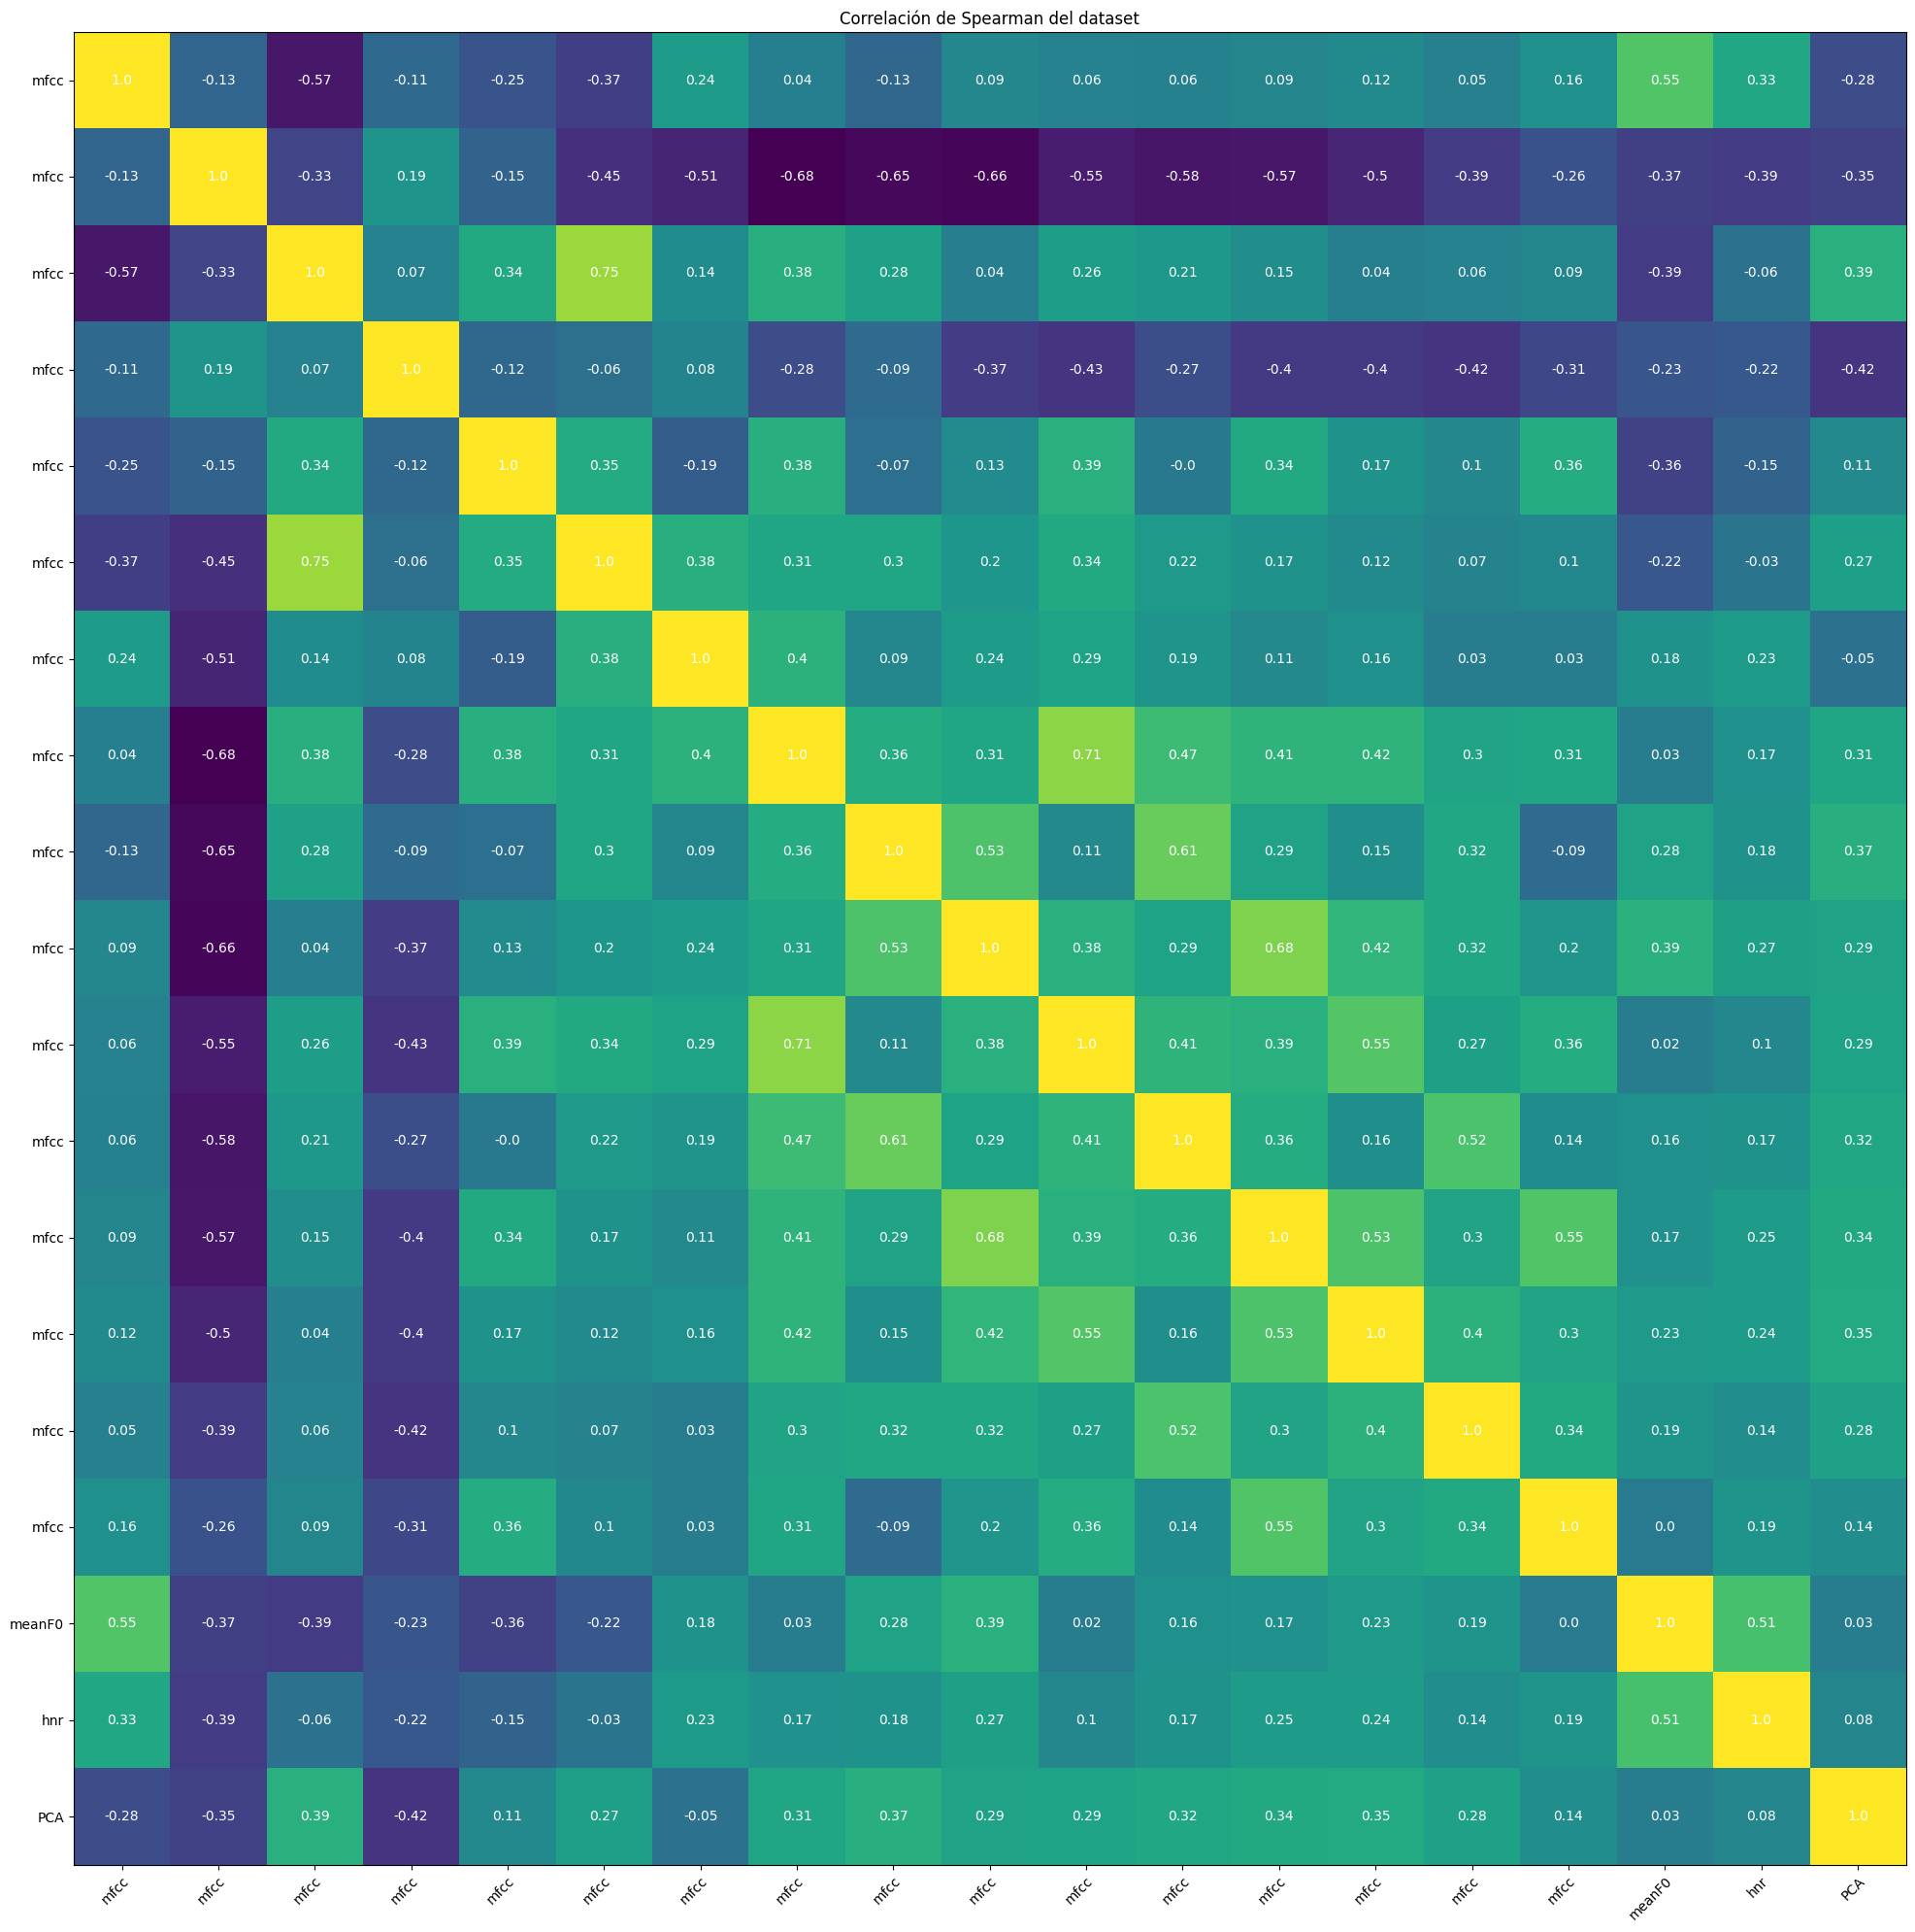

In [47]:
rho, pval = stats.spearmanr(x)
feature_names = ['mfcc'] * 16  +[
    "meanF0",
    "hnr",
    # "f_means",
    # "f_medians",
    'PCA'
]

fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(rho)

# We want to show all ticks...
ax.set_xticks(np.arange(len(feature_names)))
ax.set_yticks(np.arange(len(feature_names)))
# ... and label them with the respective list entries
ax.set_xticklabels(feature_names)
ax.set_yticklabels(feature_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(feature_names)):
    for j in range(len(feature_names)):
        text = ax.text(j, i, round(rho[i, j], 2),
                       ha="center", va="center", color="w")

ax.set_title("Correlación de Spearman del dataset")
fig.tight_layout()
plt.show()

In [21]:
dataset_no_ouliers = {'x':x_downsampled, 'y':y_downsampled}
np.save('datasets/dataset_no_outliers.npy', dataset_no_ouliers)